## <center>Chicago Crime Forecasting (2012-2017)
### <center>Anil Abraham 2023

#### <center>The goal of this project is to use machine learning techniques to forecast crime in Chicago. Particularly, predicting the location of a given crime. A thorough EDA is also included.

### Brief explanation of each column:
<ul>
<li>Unnamed: 0  - ?</li>
<li>ID - Unique crime identifier</li>
<li>Case Number - Unique case number recorded by Chicago PD</li>
<li>Date - Estimate Of when incident occured</li>
<li>IUCR - Illinois Uniform Crime Reporting code</li>
<li>Primary Type  - Primary description of IUCR code</li>
<li>Description - Secondary description of IUCR code</li>
<li>Location Description - Description of where incident occurred</li>
<li>Arrest - Whether an arrest was made or not</li>
<li>Domestic - Whether incident was domestic-related or not</li>
<li>Beat - Smallest police geographic area</li>
<li>Block/District/Ward/Community Area/X Coordinate/Y Coordinate/Latitude/Longitude/Location - Location</li>
<li>FBI Code - Classification of crime according to the FBI's National Incident-Based Reporting System (NIBRS)</li>
<li>Year - Year that incident occured</li>
<li>Updated On - Date and time that incident was last updated</li>
</ul>



### <u>Importing libraries</u>

In [30]:
import pandas as pd #Pandas for data manipulation and analysis
import numpy as np #Numpy for matrices
import geopandas as gpd #Support for geospatial data
from shapely.geometry import Point #Geographic information systems functions and analysis
import matplotlib.pyplot as plt #Matplotlib for visualisations
import seaborn as sns #Seaborn for visualisations
import plotly.express as px #Plotly for interactive map
sns.set_style("darkgrid")
pd.set_option('display.max_columns', None)

### <u>Loading dataset</u>

In [31]:
df = pd.read_csv('chicago.csv') #Read in chicago csv (2012 - 2017)

for col in df.columns.to_list(): #List all feature names
    print(col)
df.shape

Unnamed: 0
ID
Case Number
Date
Block
IUCR
Primary Type
Description
Location Description
Arrest
Domestic
Beat
District
Ward
Community Area
FBI Code
X Coordinate
Y Coordinate
Year
Updated On
Latitude
Longitude
Location


(1456714, 23)

### <u>Data preprocessing</u>

#### Only certain columns are of interest to us, so let's drop the rest.

In [32]:
df.drop(['Unnamed: 0', 'Case Number','IUCR','Updated On', 'FBI Code', 'Community Area', 'Location'
         , 'X Coordinate', 'Y Coordinate', 'Year', 'Beat'], inplace=True, axis=1) #Drop columns

#### Check for null values

In [33]:
print(f'Before replacing nulls:\n{df.isna().sum()}\n')

df['Location Description'].fillna('Unknown', inplace=True) #All null location descriptions (STREET, RESIDENCE etc) are replaced with 'Unknown'
df.loc[df['Latitude'].isna(), ('Latitude')] = 41.80 #All null locations are replaced with a unique location
df.loc[df['Longitude'].isna(), ('Longitude')] = -87.78
df.dropna(inplace=True)

print(f'After replacing nulls:\n{df.isna().sum()}')

Before replacing nulls:
ID                          0
Date                        0
Block                       0
Primary Type                0
Description                 0
Location Description     1658
Arrest                      0
Domestic                    0
District                    1
Ward                       14
Latitude                37083
Longitude               37083
dtype: int64

After replacing nulls:
ID                      0
Date                    0
Block                   0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
District                0
Ward                    0
Latitude                0
Longitude               0
dtype: int64


#### Check for duplicates

In [34]:
print(f'Before checking for duplicates\n{df.duplicated().sum()}')
df.drop_duplicates(inplace=True)
print(f'\nAfter checking for duplicates\n{df.duplicated().sum()}')

Before checking for duplicates
0

After checking for duplicates
0


#### Modify Block feature

In [35]:
df['Block'].head(3) #Blocks are in this format currently

0     013XX S SAWYER AVE
1     061XX S DREXEL AVE
2    053XX W CHICAGO AVE
Name: Block, dtype: object

In [36]:
df['Block'] = df['Block'].apply(lambda x : x[8:]) #Get main Block description without the 000xx bit. Equivalent to substring

#### Keep the most common categories and bin the rest as 'OTHER'

In [37]:
df.loc[df['Primary Type'].isin(df['Primary Type'].value_counts()[20:].index), ('Primary Type')] = 'OTHER'
df.loc[df['Description'].isin(df['Description'].value_counts()[20:].index), ('Description')] = 'OTHER'
df.loc[df['Location Description'].isin(df['Location Description'].value_counts()[20:].index), ('Location Description')] = 'OTHER'

#### Convert to int32 and int8

In [38]:
df['ID'] = df['ID'].apply(np.int32) #The Chicago dataset is quite big, so saving some memory will help
df['District'] = df['District'].apply(np.int8)

#### Convert Date to pandas datetime object, and covert the index to DatetimeIndex

In [39]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p') #Convert to datetime

df.index = pd.DatetimeIndex(df['Date']) #Convert index to DatetimeIndex
df.drop(['Date'], axis=1, inplace=True) #Drop date column

#### What are the datatypes used?

In [40]:
df.dtypes

ID                        int32
Block                    object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
District                   int8
Ward                    float64
Latitude                float64
Longitude               float64
dtype: object

#### High-level stats of the Chicago dataframe

In [41]:
df.describe()

,ID,District,Ward,Latitude,Longitude
count,1.456699e+06,1.456699e+06,1.456699e+06,1.456699e+06,1.456699e+06
mean,9.597555e+06,1.125916e+01,2.287028e+01,4.184042e+01,-8.767498e+01
std,8.083511e+05,6.904709e+00,1.380589e+01,9.332135e-02,6.791616e-02
min,2.022400e+04,1.000000e+00,1.000000e+00,3.661945e+01,-9.168657e+01
25%,9.002712e+06,6.000000e+00,1.000000e+01,4.176919e+01,-8.771913e+01
50%,9.605781e+06,1.000000e+01,2.300000e+01,4.185320e+01,-8.766812e+01
75%,1.022577e+07,1.700000e+01,3.400000e+01,4.190382e+01,-8.762891e+01
max,1.082788e+07,3.100000e+01,5.000000e+01,4.202271e+01,-8.752453e+01


##### There is nothing of use in the above.

#### Let's take a look at the first 3 and last 3 rows of the dataset

In [42]:
pd.concat([df.sort_index().head(3), df.sort_index(ascending=False).head(3)])  #Return first and last three records

,ID,Block,Primary Type,Description,Location Description,Arrest,Domestic,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2012-01-01 00:00:00,9163847,BELL AVE,THEFT,OTHER,RESIDENCE,False,False,8,18.0,41.760455,-87.679356
2012-01-01 00:00:00,8421618,CALIFORNIA AVE,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,8,15.0,41.774903,-87.693283
2012-01-01 00:00:00,9556300,CALIFORNIA AVE,DECEPTIVE PRACTICE,OTHER,OTHER,False,False,14,35.0,41.800000,-87.780000
2017-01-18 23:49:00,10820691,DICKENS AVE,ROBBERY,ARMED: HANDGUN,ALLEY,False,False,14,26.0,41.800000,-87.780000
2017-01-18 23:45:00,10820646,HOMAN AVE,WEAPONS VIOLATION,OTHER,SIDEWALK,True,False,11,27.0,41.800000,-87.780000
2017-01-18 23:40:00,10821699,WILSON AVE,ROBBERY,ARMED: HANDGUN,STREET,False,False,19,46.0,41.800000,-87.780000


##### Records begin <mark>1st January 2012</mark> and end <mark>18 January 2017</mark>

#### Types of crimes

In [43]:
for k in df['Primary Type'].value_counts(ascending=False).keys():
    print(k)

THEFT
BATTERY
CRIMINAL DAMAGE
NARCOTICS
ASSAULT
OTHER OFFENSE
BURGLARY
DECEPTIVE PRACTICE
MOTOR VEHICLE THEFT
ROBBERY
CRIMINAL TRESPASS
WEAPONS VIOLATION
PUBLIC PEACE VIOLATION
OFFENSE INVOLVING CHILDREN
PROSTITUTION
OTHER
CRIM SEXUAL ASSAULT
INTERFERENCE WITH PUBLIC OFFICER
SEX OFFENSE
HOMICIDE
ARSON


### <u>Exploratory Data Analysis</u>

#### Seasonality analysis

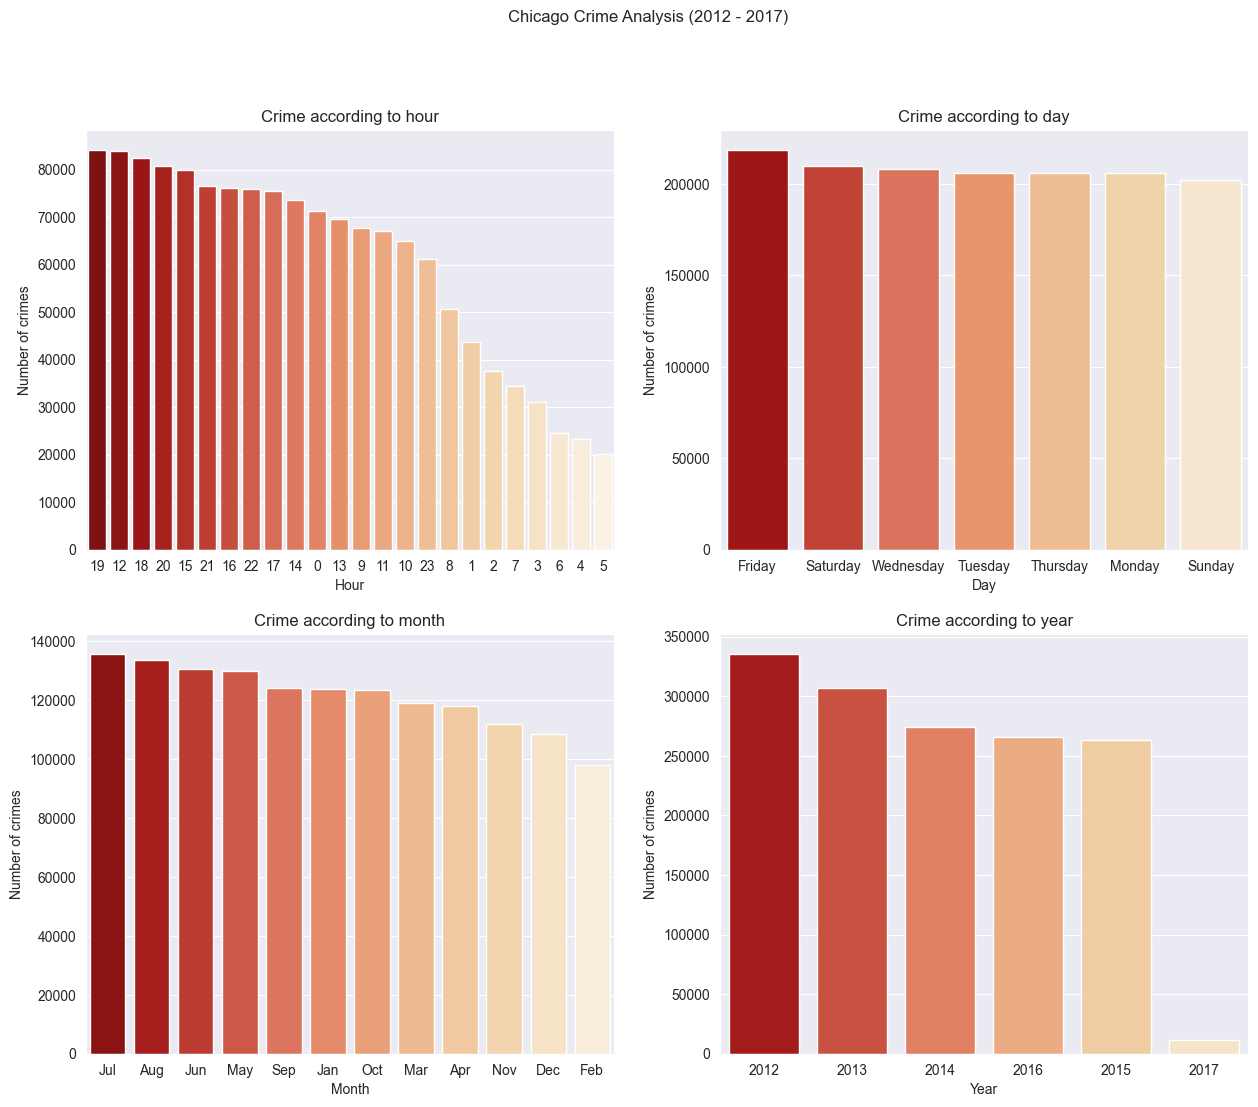

In [44]:
import calendar

df_hours = df.groupby([df.index.hour]).count()['ID'].sort_values(ascending=False) #Total crime counts grouped by hours
df_week = df.groupby([df.index.day_name()]).count()['ID'].sort_values(ascending=False) #Total crime counts grouped by day of the week
df_month = df.groupby([df.index.month]).count()['ID'].sort_values(ascending=False) #Total crime counts grouped by month
df_year = df.groupby([df.index.year]).count()['ID'].sort_values(ascending=False) #Total crime counts grouped by year


df_month = df_month.reset_index()
df_month['Date'] = df_month['Date'].apply(lambda x: calendar.month_abbr[x]) #Convert number representation of month (8) to string (August)

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

sns.barplot(x=df_hours.index, y=df_hours.values, order=df_hours.index, palette="OrRd_r", ax = axs[0,0]) #Bar plot visualizations
sns.barplot(x=df_week.index, y=df_week.values, order=df_week.index, palette="OrRd_r", ax = axs[0,1])
sns.barplot(data=df_month, x='Date', y='ID', palette="OrRd_r", ax = axs[1,0])
sns.barplot(x=df_year.index, y=df_year.values, order=df_year.index, palette="OrRd_r", ax = axs[1,1])

axs[0,0].set_title('Crime according to hour')
axs[0,0].set_xlabel('Hour')
axs[0,0].set_ylabel('Number of crimes')

axs[0,1].set_title('Crime according to day')
axs[0,1].set_xlabel('Day')
axs[0,1].set_ylabel('Number of crimes')

axs[1,0].set_title('Crime according to month')
axs[1,0].set_xlabel('Month')
axs[1,0].set_ylabel('Number of crimes')

axs[1,1].set_title('Crime according to year')
axs[1,1].set_xlabel('Year')
axs[1,1].set_ylabel('Number of crimes')

fig.suptitle('Chicago Crime Analysis (2012 - 2017)') #Main title
plt.show()

##### The above EDA suggests that most crimes in Chicago from 2012 - 2017 took place at 12pm and between 6 pm - 8 pm , with most crimes occurring on Fridays. The data suggests that most crimes in Chicago took place in July and August, and that over the years, crime gradually decreased. 2017 has a particularly low crime rate; this is because 18th January 2017 is the last recorded date for this particular dataset.

#### Analysis of crimes

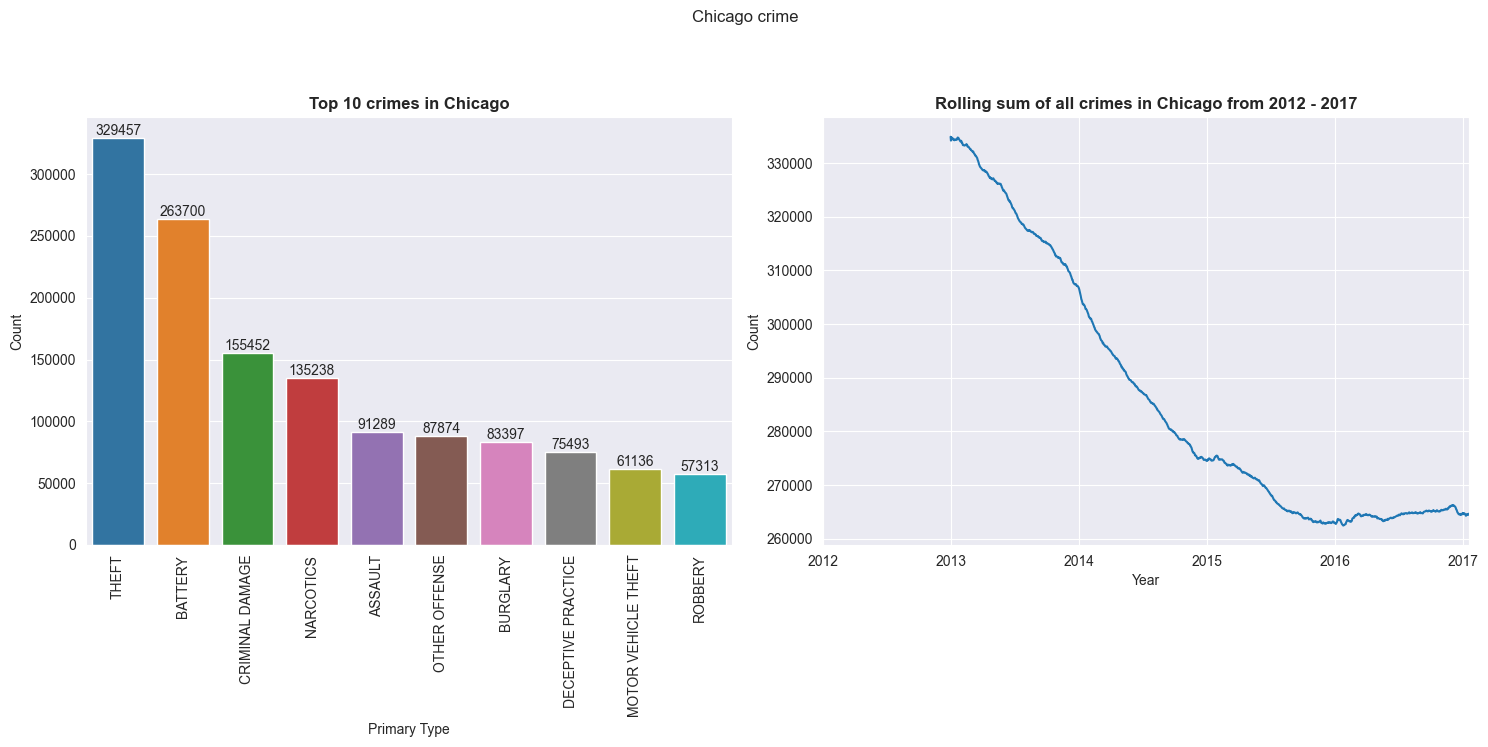

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
topcrimes = df['Primary Type'].value_counts()[:10] #Get top 10 occuring crimes

ax = sns.barplot(x=topcrimes.index, y=topcrimes.values, ax=axs[0])
ax1 = df.resample('D').size().rolling(365).sum().plot(ax=axs[1]) #Rolling sum

for i in ax.containers:
    ax.bar_label(i,) #Add value at the top of each bar

ax.set_xlabel('Primary Type')
ax.set_ylabel('Count')
ax.set_title('Top 10 crimes in Chicago', weight='bold')
ax.set_xticks(range(0,len(topcrimes.index)), topcrimes.index, rotation=90) #Rotate by 90 degrees

ax1.set_xlabel('Year')
ax1.set_ylabel('Count')
ax1.set_title('Rolling sum of all crimes in Chicago from 2012 - 2017', weight='bold')

fig.suptitle("Chicago crime", y=1.06) #Main title
plt.tight_layout()
plt.show()

##### The above graph suggests that theft, battery, and criminal damage are the three most common crimes in Chicago. The rolling sum plot also suggests that crime in Chicago is gradually decreasing throughout the years.

#### Crime counts according to whether arrests were made or not

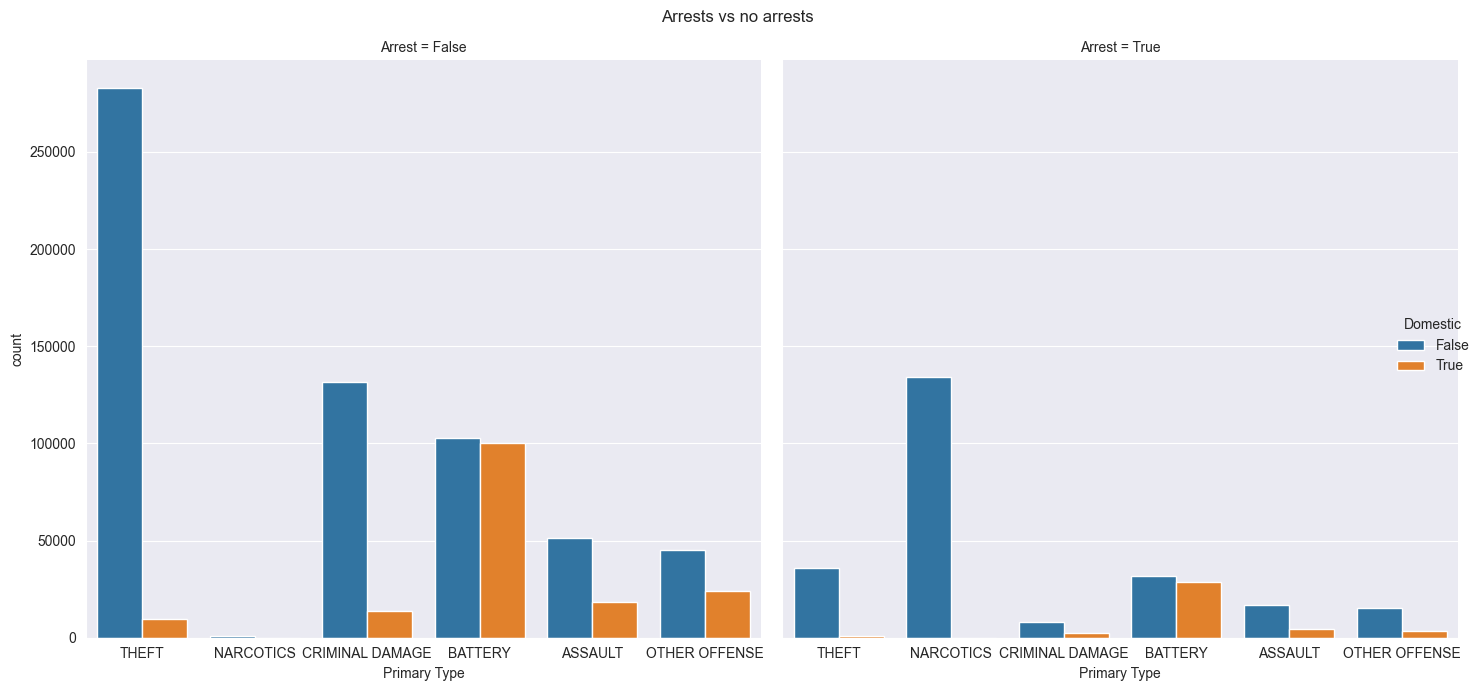

In [46]:
topcrimes = df['Primary Type'].value_counts()[:6] #Get top 6 crimes
df_grouped = df.loc[df['Primary Type'].isin(topcrimes.index)].groupby(['Arrest', 'Domestic', 'Primary Type']).size().reset_index(name='count').sort_values('count', ascending=False) #Arrest vs no arrests according to domestic crimes
sns.catplot(df_grouped, x='Primary Type', y='count', hue='Domestic', kind='bar', col='Arrest', height=7) #Plot using FacetGrid/catplot

plt.suptitle('Arrests vs no arrests') #Main title
plt.tight_layout()
plt.show()

##### The above categorical plot suggests that in Chicago from 2012-2017, most crimes that lead to no arrest were thefts, and most crimes that led to arrests were narcotics. Most domestic-related crimes were linked to battery and assault.

#### Brief overview of Chicago crime trends according to the top 6 crimes

Text(0.5, 1.05, 'Chicago crimes')

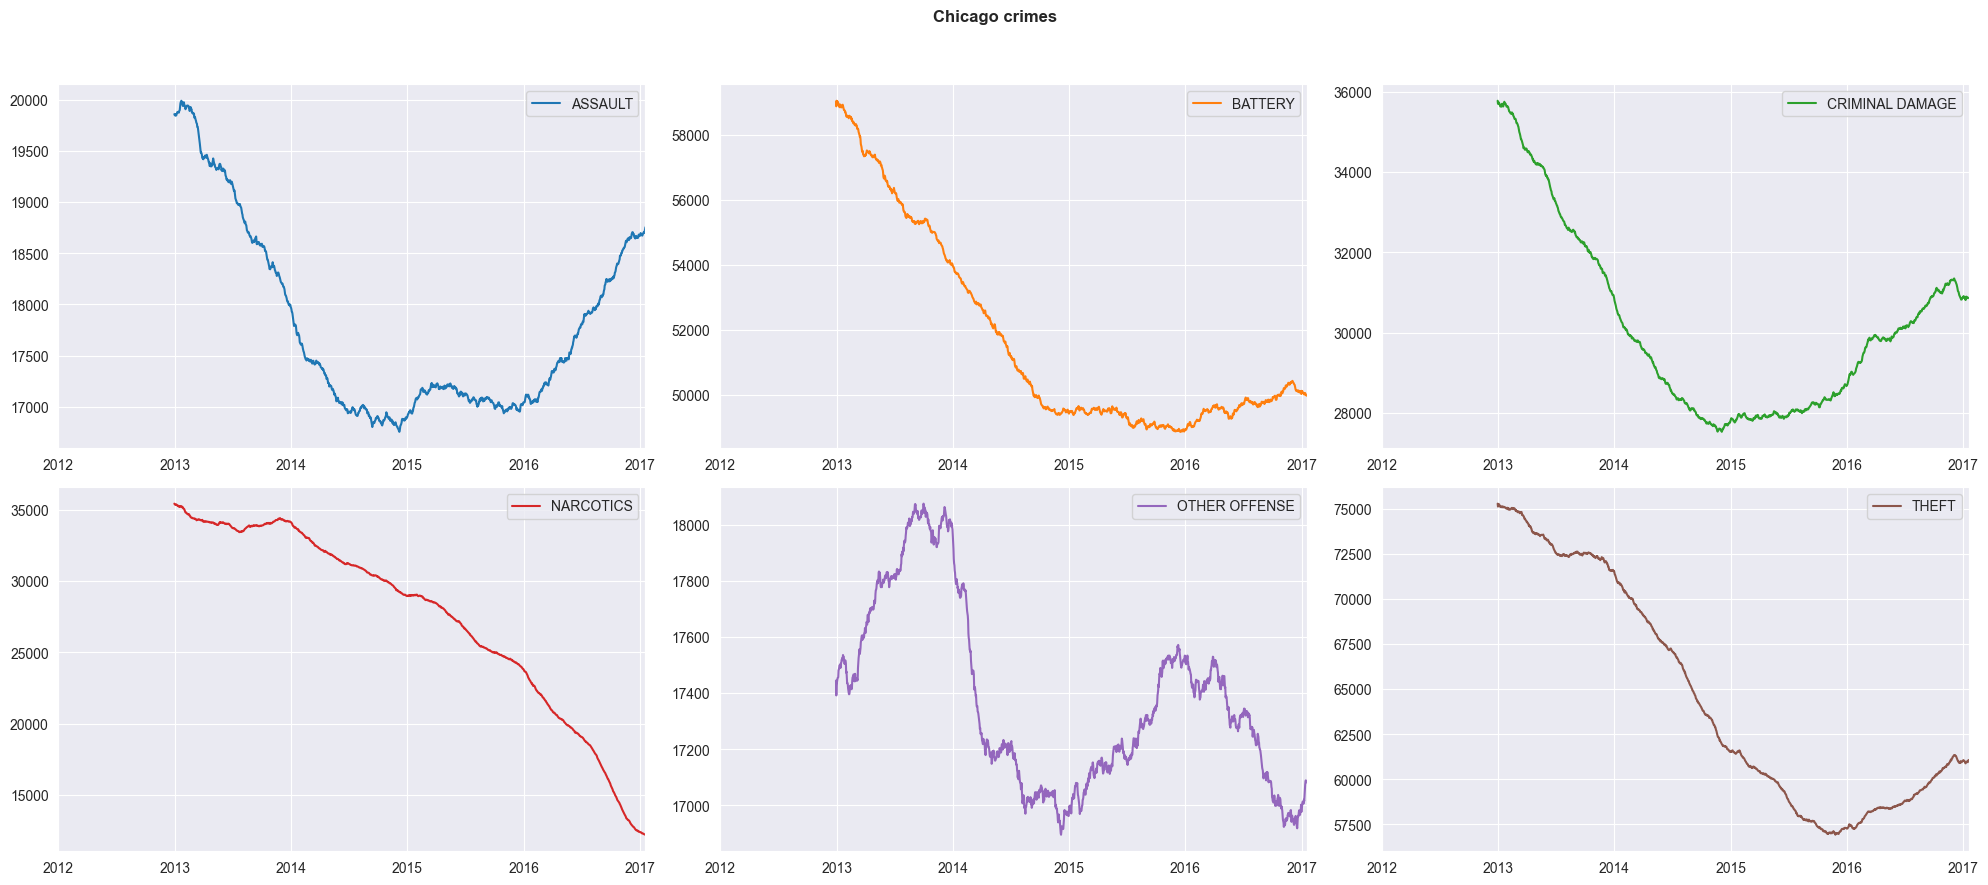

In [47]:
topcrimes = df['Primary Type'].value_counts()[:6] #Get top 6 crimes

topcrimes = df.loc[df['Primary Type'].isin(topcrimes.index.to_numpy())] #All crimes that fall under the top 6 crimes
pivot = topcrimes.pivot_table('ID', aggfunc=np.size, index=topcrimes.index.date, columns='Primary Type') #Create pivot table
pivot.index = pd.DatetimeIndex(pivot.index)
pivot.rolling(365).sum().plot(figsize=(20, 12), sharex=False, sharey=False, subplots=True, layout=(3, 3)) #Rolling sum plot of each 6 crimes over the years

plt.tight_layout()
plt.suptitle("Chicago crimes", y=1.05, weight='bold') #Main title

##### This EDA suggests that narcotic, battery, and theft-related crimes have drastically decreased over the years, whereas assaults and criminal damage related crimes have dipped and are rapidly increasing again.

#### Interactive heatmap of crimes in Chicago

In [48]:
#Create heatmap dataframe
step = 0.01
to_bin = lambda x: np.floor(x / step) * step
heatmap = df.copy()
heatmap["Latitude"] = to_bin(df["Latitude"])
heatmap["Longitude"] = to_bin(df['Longitude'])
heatmap = heatmap.groupby(["Latitude", "Longitude", "Block"]).count()['ID'].reset_index(name='Count') #The binning prevents too many clusters of hotspots everywhere. We then count all the crimes per 0.01 lat/longitude radius.

heatmap = heatmap[(heatmap["Latitude"] != 41.800000000000004) & (heatmap["Longitude"] != -87.78)] #The heatmap will list the Unknown location as a hotspot as there are a large number of unknown locations, therefore we remove this from visualisation.

def first_occurrence(series):
    return series.iloc[0] #Return only the first occurence of the lat/long pair so we can sum the count

heatmap = heatmap.sort_values("Count", ascending=False).groupby('Block')\
    .agg({'Latitude': first_occurrence, 'Longitude': first_occurrence, 'Count': 'sum'}).reset_index().sort_values("Count", ascending=False) #The same street occurs for various lat/long coord pairs, therefore we sum them up to get one result.

heatmap = heatmap[heatmap['Count'] > 3000] #Limit to areas with high crime counts


In [49]:
#Plotting
fig = px.scatter_mapbox(heatmap, lat="Latitude", lon="Longitude",
                    zoom=9.7, height=700, size_max=30, color_continuous_scale=['Yellow', 'orange', 'red', 'maroon'],color="Count", hover_data=["Count"], size='Count', hover_name="Block") #Create interactive map
fig.update_layout(mapbox_style="carto-darkmatter", margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

##### The above interactive map depicts major hotspots as large red circles. The larger/redder the circle, the more crimes were committed in that area. Most hotspots are overlapping due to the latitude/longitude binning, as there may be many streets within a latitude/longitude step (0.01).

### Static heatmap of Chicago crime hotspots

##### Create geodataframe

In [50]:
heatmap_top5 = heatmap.sort_values('Count', ascending=False)[:5] #Get the top 5 crime hotspots

heatmap_top5['Size'] = heatmap_top5['Count'] / 15 #Size column used for adjusting marker bubble size
geo_df = gpd.GeoDataFrame(heatmap_top5, geometry=[Point(xy) for xy in zip(heatmap_top5['Longitude'], heatmap_top5['Latitude'])]) #Create gdf

##### Plot

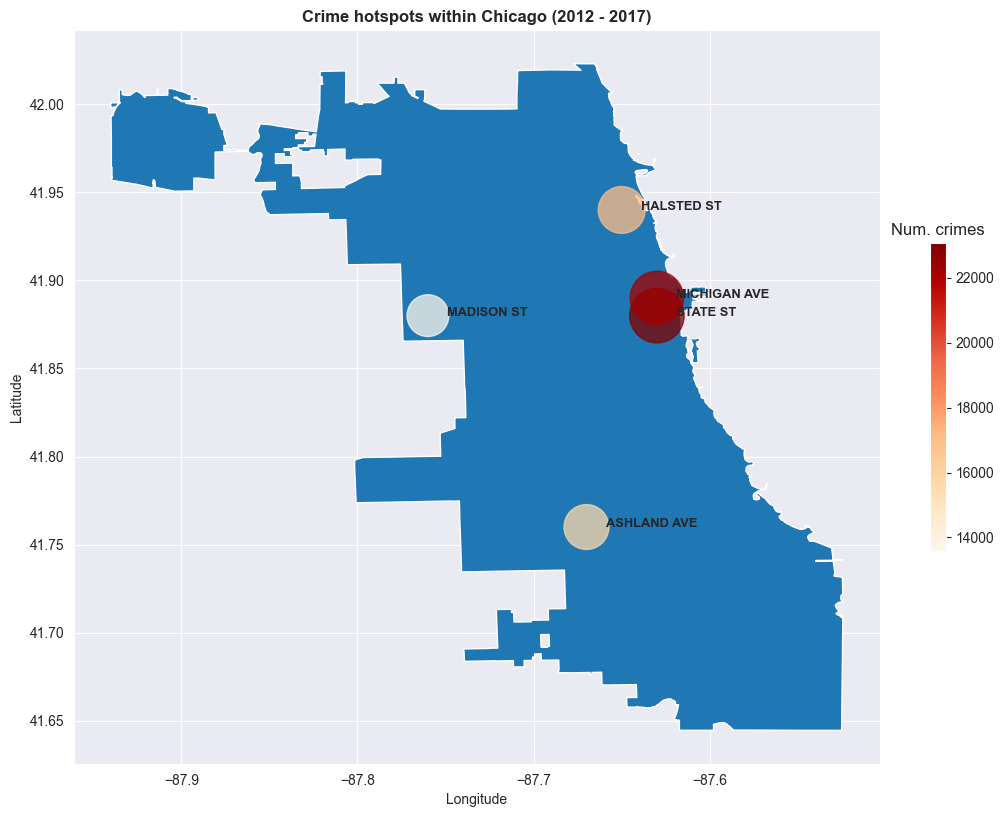

In [51]:
fig, ax = plt.subplots(figsize=(13,10))
map = gpd.read_file("chicago/chicago.shp") #Read in chicago shape file
map.plot(ax=ax, aspect=1)
geo_df.plot(aspect=1, column='Count', ax=ax, cmap='OrRd', markersize='Size', legend=True, alpha=0.75, legend_kwds={'shrink': 0.4}) #Plot the latitude longitude pairs onto the same Chicago map.

for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df['Block']):
    ax.annotate(label, xy=(x, y), xytext=(14,0), textcoords="offset points", weight='bold', fontsize=9.3) #Labelling each hotspot

ax.get_figure().get_axes()[1].set_title("Num. crimes") #Legend title
plt.title('Crime hotspots within Chicago (2012 - 2017)', weight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Barplot of Top 5 hotspots in Chicago

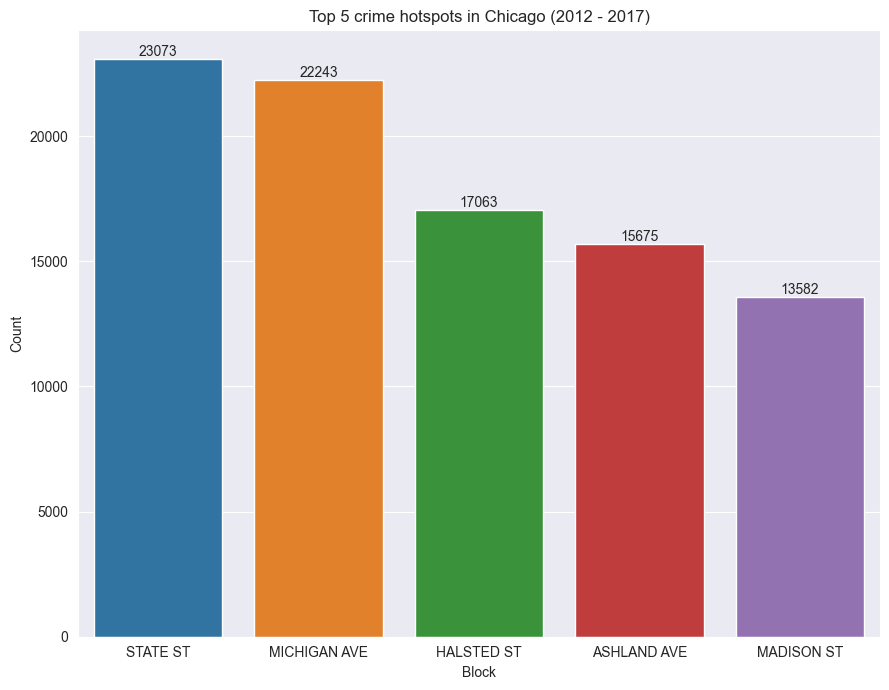

In [52]:
plt.figure(figsize=(9,7))
ax = sns.barplot(heatmap_top5, x='Block', y='Count') #Barplot of top 5 hotspots

for i in ax.containers:
    ax.bar_label(i,) #Depict crime count over each bar
    
plt.title("Top 5 crime hotspots in Chicago (2012 - 2017)")
plt.tight_layout()
plt.show()

##### According to the heatmap and barplot above, most crimes in Chicago between 2012 - 2017 were committed in State Street, Michigan Avenue, and Halsted Street.

### <u>Machine Learning</u>

#### Import

In [53]:
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier, cv, Pool
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from time import process_time
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from joblib import dump, load

#### Data aquisition

In [54]:
df = df[df['District'] != 13] # There exists a single row with District = 13, and it is not appearing in the training set. As this class has only one row, we will remove it.
X = df.drop(['District', 'ID', 'Latitude', 'Longitude', 'Block'], axis=1) #Dropping Latitude and Longitude because most models will get near perfect accuracy AKA overfitting.
y = df['District'] #We will predict District.

#### Sampling/split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42) #80% train, 20% test

#### Categorical encoding

In [56]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_transformed = oe.fit_transform(X_train) #Feature encode all categorical columns
X_test_transformed = oe.transform(X_test)

#### Hyperparameter space

In [57]:
rand_grid = { #Random forest grid
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [2, 3, 4],
 'n_estimators': [20, 50, 100, 200]}

decision_grid = { #Decision tree grid
    'criterion': ['gini', 'entropy'],        
    'splitter': ['best', 'random'],           
    'min_samples_split': [2, 5, 10],         
    'min_samples_leaf': [1, 2, 4],           
    'max_features': ['sqrt', 'log2'],                  
}

NB_grid = { #Gaussian Naive Bayes grid
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

knn_grid = { #k-NN grid
    'n_neighbors': [3, 5, 7, 9],        
    'weights': ['uniform', 'distance'], 
    'p': [1, 2],                        
    'metric': ['euclidean', 'manhattan']
}

ada_grid = { #AdaBoost grid
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.1, 0.5, 1.0]
}

cat_grid = { #CatBoost grid
    'iterations': 1000,      
    'learning_rate': 0.05, 
    'depth': 6,                  
    'l2_leaf_reg': 5,             
    'border_count': 64,
    "loss_function": "MultiClass"
}

xg_grid = { #XGBoost grid
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 6]
        }

space = [rand_grid,decision_grid, cat_grid, ada_grid, NB_grid, knn_grid, xg_grid] #List of grids


#### Algorithm training

In [40]:
#Handles the results dataframe
def appendToDf(avg, std, y_pred, y_test, name, results):
    '''Groups the results of each classifier into a pandas dataframe'''

    avg = round(avg.mean()*100, 2) #Average and standard deviation of CV results
    std = round(std.mean()*100,2)
    accuracy = round(accuracy_score(y_test, y_pred)*100,2) #Get accuracy, precision, recall, and f1-score of each model
    precision = round(precision_score(y_test, y_pred, average="weighted")*100,2)
    recall = round(recall_score(y_test, y_pred, average="weighted")*100,2)
    f1 = round(f1_score(y_test, y_pred, average="weighted")*100,2)
    print(f"{name} CV Test {avg}% std: {std}") if name != 'CatBoostClassifier' else print(f"{name} CV Test loss {avg} std: {std}")#Test score CV results
    print(f"{name} test accuracy score: {accuracy}%") #Accuracy on test set
    return pd.concat([results, pd.DataFrame({"Name":[name], "Accuracy":[accuracy], "Precision":[precision], "Recall":[recall], "F1" : [f1]})]) #Return updated dataframe

In [41]:
#Handles the training, hyperparameter tuning, validation, and testing of models
def modelEvaluation(clf, scoring):
    '''Trains each model using 5-fold CV and RandomizedSearch for hyperparameter tuning. 
    Pickles each model for later use. Returns dataframe of metrics per model'''

    cval = KFold(n_splits=5) #5-fold CV
    results = pd.DataFrame({}, columns=["Name", "Accuracy", "Precision", "Recall", "F1"]) #Create empty dataframe
    with open('Results/params.txt', 'w') as f: #Write model with best parameters to text file
        for i in range(len(clf)): #Loop through each model
            start = process_time() #Begin process timer
            name = clf[i].__class__.__name__ #Get model name
            model = clf[i]
            search = None
            
            if name == 'CatBoostClassifier': #CatBoostClassifier does not seem to work with RandomizedSearchCV.
                model.fit(X_train, y_train, cat_features=[0,1,2,3,4]) #CatBoost can handle categorical encoding on its own
                y_pred = model.predict(X_test)
                #Using cross validation on this large dataset seems to run infinitely.
                
                #cv_data = Pool(data=X_train, label=y_train, cat_features=[0,1,2,3,4]) #CatBoost's internal data structure Pool is needed for CV
                #scores = cv(cv_data, space[i], fold_count=2, verbose=False) #Get CV of multiclass losses
                #avg = scores['train-MultiClass-mean'] #These are not CV mean accuracies, but rather the losses
                #std = scores['train-MultiClass-std']
                temp_df = pd.DataFrame(data={'col1': [0, 0]}) #Not able to do CV, so use a blank CV score for now.
                avg = temp_df['col1'].mean()
                std = temp_df['col1'].mean()
                results = appendToDf(avg, std, y_pred, y_test, name, results) #Add results to dataframe

            elif name == 'XGBClassifier':  #n_jobs = 1 because XGBoost is already using the GPU to train each model
                le = LabelEncoder() #XGBoost requires that y is first encoded
                y_train_transformed = le.fit_transform(y_train)
                y_test_transformed = le.transform(y_test)
                search = RandomizedSearchCV(model, space[i], n_jobs=1, n_iter=5, refit=True, scoring=scoring, cv=cval, random_state=42)
                search.fit(X_train_transformed, y_train_transformed)
                y_pred = search.predict(X_test_transformed)
                avg = search.cv_results_['mean_test_score']
                std = search.cv_results_['std_test_score']
                results = appendToDf(avg, std, y_pred, y_test_transformed, name, results) #Add results to dataframe

            else: #Run using 7 cores
                search = RandomizedSearchCV(model, space[i], n_jobs=7, n_iter=5, refit=True, scoring=scoring, cv=cval, random_state=42)
                search.fit(X_train_transformed, y_train) #Using encoded features
                y_pred = search.predict(X_test_transformed)
                avg = search.cv_results_['mean_test_score']
                std = search.cv_results_['std_test_score']
                results = appendToDf(avg, std, y_pred, y_test, name, results) #Add results to dataframe

            f.write(f'{name}: {search.best_params_}') if name != 'CatBoostClassifier' else f.write(f'{name}: {model.get_params()}') #Write best parameters per model to file
            dump(search.best_estimator_, f'Models/{name}.joblib') if name != 'CatBoostClassifier' else dump(model, f'Models/{name}.joblib') #Pickle each model for later use
            
            end = process_time() #Record total processing time taken per model
            print(f"Total time taken: {end-start}s\n")
        
    return results.reset_index(drop=True)

In [42]:
#Using the following 7 classifiers.  
clf = [RandomForestClassifier(random_state=42),
       DecisionTreeClassifier(random_state=42),
      CatBoostClassifier(random_state=42, allow_writing_files=False, task_type="GPU", devices='0:1', iterations=1000, logging_level='Silent'), #Runs on GPU
      AdaBoostClassifier(random_state=42),
      GaussianNB(),
      KNeighborsClassifier(),
      xgb.XGBClassifier(objective='multi:softmax', random_state=42, subsample = 0.8, min_child_weight = 10, max_depth = 6, gamma = 0, colsample_bytree = 1, tree_method = "hist", device = "cuda", verbosity=0) #Runs on GPU
       ]

#### Putting it all together

In [43]:
import warnings
warnings.filterwarnings('ignore') #AdaBoost model results in precision warnings as there are labels with no predicted samples. Surpress these.

d = modelEvaluation(clf, 'accuracy') #Run tests
d.to_csv('Results/results.csv', index=False) #Save results to CSV

RandomForestClassifier CV Test 70.78% std: 0.11
RandomForestClassifier test accuracy score: 70.98%
Total time taken: 67.5625s

DecisionTreeClassifier CV Test 69.87% std: 0.21
DecisionTreeClassifier test accuracy score: 70.47%
Total time taken: 0.59375s

CatBoostClassifier CV Test loss 0.0 std: 0.0
CatBoostClassifier test accuracy score: 71.16%
Total time taken: 456.9375s

AdaBoostClassifier CV Test 21.13% std: 3.15
AdaBoostClassifier test accuracy score: 23.5%
Total time taken: 83.671875s

GaussianNB CV Test 32.62% std: 0.35
GaussianNB test accuracy score: 32.81%
Total time taken: 0.6875s

KNeighborsClassifier CV Test 67.5% std: 0.13
KNeighborsClassifier test accuracy score: 68.38%
Total time taken: 6.6875s



In [38]:
#XGBClassifier CV Test 70.94% std: 0.09
#XGBClassifier test accuracy score: 71.07%
#Total time taken: 336.71875s

XGBClassifier CV Test 70.94% std: 0.09
XGBClassifier test accuracy score: 71.07%
Total time taken: 336.71875s



#### Results

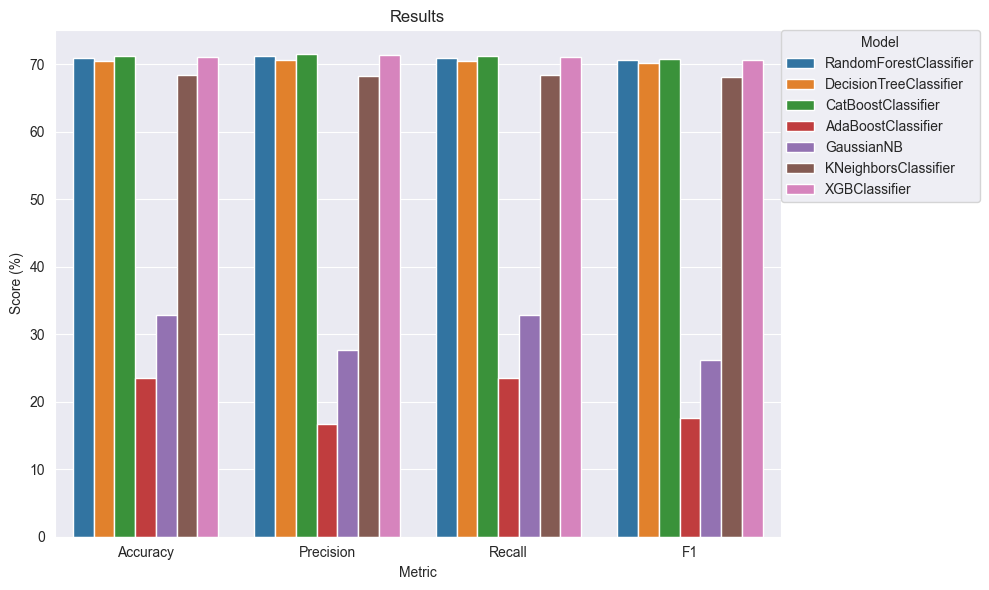

In [44]:
d = pd.read_csv('Results/results.csv')
melted_df = d.melt(id_vars="Name", value_vars=["Accuracy", "Precision", "Recall", "F1"], var_name="Metric")

# Create result barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x="Metric", y="value", hue="Name")
plt.title("Results")
plt.xlabel("Metric")
plt.ylabel("Score (%)")
plt.legend(title="Model", loc=2, bbox_to_anchor=(1, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

### <u>Results and Discussion</u>

#### EDA

EDA on the Chicago crime dataset revealed various underlying trends and patterns. The complex nature of this dataset containing 23 features allowed for a rich analysis to be produced. The following sections explore the seasonality analysis, crime trends over the years, types of crimes committed, and hotspot analysis.

##### <u><b>Seasonality analysis</u></b>

Seasonality analysis suggests that most crimes in Chicago from 2012-2017 took place at 12 pm and between 6 pm - 7 pm, with most crimes occurring on Fridays. Crimes were least likely to occur on Sundays and in the early morning from 1 am - 7 am. The data suggests that most crimes in Chicago took place in July and August, and that 2012 had the highest overall crime count. The least crime took place in 2017 according to EDA. However, we cannot assume this to be true as the Chicago dataset's last record ends on January 18, 2017. Therefore, we are missing a years worth of data. The least crime is committed in the months of November, December, and February. 

##### <u><b>Yearly crime trends</u></b>

The seasonality analysis revealed that 2012 had the highest overall crime count, and that 2013-2017 saw a decline in crime. However, this does not accurately explain whether crime in Chicago is actually decreasing over the years. Therefore, a rolling sum of all crimes from 2012-2017 was created. This line graph explains that crime was in fact gradually decreasing from 2012-2016, and thereafter started increasing again until 2017. 

##### <u><b>Types of crimes committed</u></b>

There are 21 unique categories of crimes committed. Examples include criminal trespassing, homicides, and arson. The top 5 crimes in Chicago from 2012-2017 were: Theft, battery, criminal damage, narcotics, and assault. Theft and battery crime counts are significantly higher than that of the remaining crimes. Thus, the Chicago police department should focus on mitigating these specific crimes first. Theft is the most common crime in Chicago, which could suggest that many people feel entitled to steal, or have a family to feed and are desperate.

##### <u><b>Hotspot analysis</u></b>

A hotspot analysis was conducted to reveal the most dangerous areas in Chicago from 2012 - 2017. As crimes are recorded at the incident level, one must first group various areas of crime together for the analysis to be useful. A crime heatmap was then created to depict the total crime counts per area, revealing that State Street, Michigan Avenue, and Halsted Street were the most dangerous areas in Chicago. These results can aid law enforcement in focusing on these areas through efficient police resource utilization. This prevents police resources from being wasted on areas with lower crime such as North Avenue.

#### Machine Learning

The structure of the Chicago dataset is similar to the Boston crime dataset. The majority of crime forecasting systems in literature have used similar datasets in terms of structure, features, and number of data points. The Chicago dataset contains 23 features, allowing for robust crime forecasting models to be implemented for use in prediction.

This experiment aimed to predict the district of each crime committed, given the primary type, description, location description, arrest, domestic, and ward. This feature selection is credited to Tamir et al's paper, where they used similar features to achieve high accuracies. Latitude and longitude were excluded as they are highly correlated with district, meaning these coordinates directly predict the district. The results of this experiment are explored in the following sections.

<table border="1" class="dataframe">
<caption style='margin:20px;background-color:cyan; color:black';><b>Table 1: Performance metrics of various classifiers on the Chicago dataset</b></caption>
  <thead>
    <tr style="text-align: right;">
      <th>Ranking</th>
      <th>Name</th>
      <th>Accuracy</th>
      <th>Precision</th>
      <th>Recall</th>
      <th>F1</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>3</th>
      <td>RandomForestClassifier</td>
      <td>70.98</td>
      <td>71.23</td>
      <td>70.98</td>
      <td>70.64</td>
    </tr>
    <tr>
      <th>4</th>
      <td>DecisionTreeClassifier</td>
      <td>70.47</td>
      <td>70.64</td>
      <td>70.47</td>
      <td>70.19</td>
    </tr>
    <tr>
      <th>1</th>
      <td>CatBoostClassifier</td>
      <td>71.16</td>
      <td>71.46</td>
      <td>71.16</td>
      <td>70.80</td>
    </tr>
    <tr>
      <th>7</th>
      <td>AdaBoostClassifier</td>
      <td>23.50</td>
      <td>16.72</td>
      <td>23.50</td>
      <td>17.60</td>
    </tr>
    <tr>
      <th>6</th>
      <td>GaussianNB</td>
      <td>32.81</td>
      <td>27.67</td>
      <td>32.81</td>
      <td>26.23</td>
    </tr>
    <tr>
      <th>5</th>
      <td>KNeighborsClassifier</td>
      <td>68.38</td>
      <td>68.32</td>
      <td>68.38</td>
      <td>68.15</td>
    </tr>
    <tr>
      <th>2</th>
      <td>XGBClassifier</td>
      <td>71.07</td>
      <td>71.45</td>
      <td>71.07</td>
      <td>70.67</td>
    </tr>
  </tbody>
</table>

All models performed well in predicting a crime's district, with the exception of Gaussian Naive Bayes and AdaBoostClassifier. The best performing model was CatBoostClassifier with an accuracy and F1-score of 71.16% and 70.80%, respectively. The worst performing model was AdaBoostClassifier, with an accuracy and F1-score of 23.50% and 17.60%, respectively. Gaussian Naive Bayes also performed poorly, with an accuracy and F1-score of 32.81% and 26.23%, respectively. The remaining models performed within an accuracy range of 68.38% - 71.07%. All models yielded similar precision and recall values when compared to the accuracy achieved. However, the precision of Gaussian Naive Bayes and AdaBoostClassifier see a significant decrease compared to its achieved accuracy and recall values, with a low precision score of 27.67% and 16.72%.

Given the above results, a robust crime forecasting system can be developed for Chicago using its respective crime dataset. The scores achieved for each model are high. The best model using the Boston dataset achieved an accuracy of 88.4%. Gaussian Naive Bayes performed poorly, possibly due to the lack of class independence. AdaBoostClassifier performed the worst overall, likely due to overfitting and an insufficient number of weak learners. The best F1-score was also achieved by CatBoostClassifier, with a score of 70.80%. These results indicate that the Chicago crime dataset is a good candidate for use in crime forecasting.

## <center><b>Thanks for reading!</b>